----------------------
## Classify Your Own Digit  

- A simple notebook for drawing onto a blank canvas so that users may write their own test samples to input into a trained neural net in Keras. 

    - This code is borrowed from [Michael Pearce](https://github.com/scrambledpie/Drawing-Mnist-and-Cifarizing-image-files/blob/master/DrawMyOwnNumbers.ipynb)


- Tkinter is used to provide a canvas for a user to draw on, this is then saved on the hard disk (unfortunately there is not a more elegant method). The saved image is loaded into python and a Gaussian blur is applied. This blurred image is then sampled at a `28*28` grid around the centre of mass and clipped to produce an MNIST stylized version of the original picture.


- Information on the Minst images and all the records for various methods can be found [here](http://yann.lecun.com/exdb/mnist/).

### The drawing function for inputing one's own writing!
The following code loads packages and defines a function that creates a canvas and anyone can draw on it, the drawing is converted to Mnist style. The function Will also take a keras model and run prediction from the hand drawn image yielding a probabilty distribution and plotting the results.

In [1]:
from tkinter import *
import time
from PIL import Image, ImageDraw
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def DrawMyOwnNumbers(Kerasmodel=None,CanvasWidth=200):
    DrawnOutMatrix=0
    width=CanvasWidth
    white = (255, 255, 255)
    black = (0, 0, 0)

    b1 = "up"
    xold, yold = None, None    

    def b1down(event):
        nonlocal b1
        b1 = "down"           

    def b1up(event):
        nonlocal b1, xold, yold
        b1 = "up"
        xold = None
        yold = None
    def motion(event):
            if b1 == "down":
                nonlocal xold, yold
                if xold is not None and yold is not None:
                    event.widget.create_line(xold,yold,event.x,event.y)
                    draw.line([xold,yold,event.x,event.y], black)
                xold = event.x
                yold = event.y
    root = Tk()
    drawing_area = Canvas(root,width=width,height=width)
    image1 = Image.new("RGB", (width, width), white)
    draw = ImageDraw.Draw(image1)
    drawing_area.pack()
    drawing_area.bind("<Motion>", motion)
    drawing_area.bind("<ButtonPress-1>", b1down)
    drawing_area.bind("<ButtonRelease-1>", b1up)
    
    def handle_click():
        nonlocal DrawnOutMatrix
        nonlocal root
        root.destroy()
        %matplotlib inline


        filename = "OwnHandWrittenDigit.bmp"
        image1.save(filename)
        II=np.asarray(mpimg.imread(filename))
        II=np.apply_along_axis(np.min,2,II)
        

        data=np.asarray([[i,j] for i in range(width) for j in range(width) if II[j,i]==0]).astype('float64')
        datax=data[:,0]
        datay=data[:,1]
        
        # centre and scale the pixels
        datax -= np.mean(datax)
        datay -= np.mean(datay)
        scaling = np.max(np.abs([datax.min(),datax.max(),datay.min(),datay.max()]))
        datax *= 1/scaling
        datay *= 1/scaling
      
        posn = np.linspace(-1.2,1.2, 28)
        sx = -0.5*(1/0.06)**2
        def kde(x,y):
            return(np.min([np.sum(np.exp(sx*((x-datax)**2+(y-datay)**2))),5]))

        output=np.asarray([[kde(x,y) for x in posn] for y in posn])
        output=output/output.max()
        output1=np.asarray([[[ [output[j,i]] for i in np.arange(28)] for j in np.arange(28)]])
        DrawnOutMatrix=output1[0,:,:,0]
        
        if Kerasmodel:
            p= Kerasmodel.predict_proba(output1,verbose=1==2)[0]

            f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))
            ax1.imshow(255-II,cmap='Greys')

            def PlotMnist(inn,ax):
                ax.imshow(inn[0,:,:,0],cmap='Greys')

            PlotMnist(output1,ax2)
            ax3.bar(np.arange(10),p,0.8,color='g')


    Button(root, text='classify!', command=handle_click).pack()
    root.mainloop()
    return DrawnOutMatrix

### Train a quick model on Mnist numbers

This first block of code defines a simple neural network, imaginatively called "model", 784 inputs for `28*28` pixels, then two hidden layers of 128 nodes each, the final layer is 10 outputs giving the probabilty of each class, 0, 1, .... 9. This model is trained for one epoch (one lap of the training set) and reaches 91.16% test set accuracy, more epochs and layers can be added to improve accuracy. This is a simplified version of code from the brilliant [Francois Chollet](https://github.com/fchollet)

In [3]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 4

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 2s 39us/step - loss: 0.3180 - acc: 0.9067 - val_loss: 0.1663 - val_acc: 0.9486
Epoch 2/4
60000/60000 [==============================] - 2s 36us/step - loss: 0.1330 - acc: 0.9605 - val_loss: 0.1264 - val_acc: 0.9612
Epoch 3/4
60000/60000 [==============================] - 2s 36us/step - loss: 0.0928 - acc: 0.9717 - val_loss: 0.1163 - val_acc: 0.9640
Epoch 4/4
60000/60000 [==============================] - 2s 35us/step - loss: 0.0713 - acc: 0.9779 - val_loss: 0.0851 - val_acc: 0.9726
Test loss: 0.08508944975140038
Test accuracy: 0.9726


### Call the DrawMyOwnNumbers function

We've trained a model, lets see if it can recognise our writing. A white box will appear, draw your number and click classify! The white box will remain but just click back to this window to continue. Then the code will convert the drawing to Mnist style and put it onto your keras model which will then be used to predict what number the drawing is!

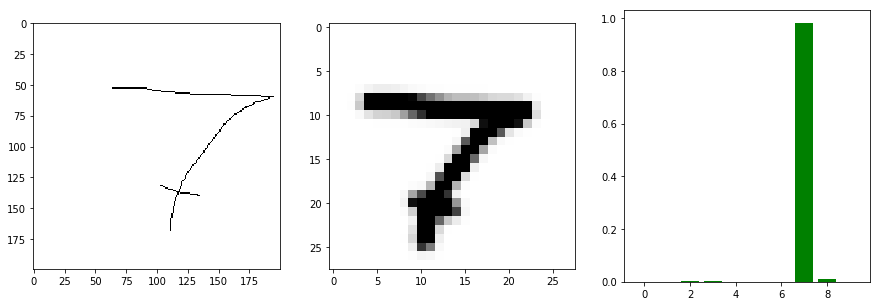

In [4]:
A=DrawMyOwnNumbers(model)